### 1. Intro 


- The HR dataset

**Note:**  source on [Kaggle](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv).

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

- Mục tiêu trong dự án này là phân tích dữ liệu do phòng nhân sự thu thập và xây dựng một mô hình dự đoán liệu một nhân viên có rời khỏi công ty hay không. 

- Xác định được các yếu tố góp phần khiến họ nghỉ việc. Vì việc tìm kiếm, phỏng vấn và tuyển dụng nhân viên mới tốn kém và mất nhiều thời gian nên việc tăng tỷ lệ giữ chân nhân viên sẽ có lợi cho công ty.

1. Mục tiêu là phân tích tình trạng luân chuyển nhân viên và xác định các yếu tố chính ảnh hưởng đến tình trạng hao hụt, cho phép công ty thực hiện các biện pháp chủ động để giữ chân nhân viên và cải thiện quản lý lực lượng lao động.

2. Những quan sát ban đầu từ quá trình khám phá dữ liệu bao gồm:
- Có sự mất cân bằng trong biến mục tiêu 'left', cho thấy hầu hết nhân viên ở lại công ty.
- Một số nhân viên có thời gian công tác cao, trong khi những người khác có thời gian công tác tương đối thấp.
- Có nhiều mức lương và phòng ban khác nhau được thể hiện trong bộ dữ liệu.

3. Mô hình và công nghệ sử dụng :
- Python và các thư viện (ví dụ: Pandas, NumPy, Seaborn, Matplotlib,...) để phân tích và trực quan hóa dữ liệu.
- Thuật toán học máy Logistic Regression, Random Forest 
- GridSearchCV để điều chỉnh siêu tham số và các số liệu đánh giá như độ chính xác, độ chính xác, khả năng thu hồi, điểm F1 và AUC-ROC để đánh giá hiệu suất của mô hình.

### 2. Import 

In [71]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


### 3. Visualization

#### 3.1 PS Data

In [72]:
df_visualization = pd.read_csv('./HR_capstone_dataset.csv')

In [73]:
df_visualization = df_visualization.drop_duplicates()

#### 3.2 Infor Data 

In [74]:
df_visualization.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11991 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     11991 non-null  float64
 1   last_evaluation        11991 non-null  float64
 2   number_project         11991 non-null  int64  
 3   average_montly_hours   11991 non-null  int64  
 4   time_spend_company     11991 non-null  int64  
 5   Work_accident          11991 non-null  int64  
 6   left                   11991 non-null  int64  
 7   promotion_last_5years  11991 non-null  int64  
 8   Department             11991 non-null  object 
 9   salary                 11991 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.0+ MB


- Từ con số dưới đây cho ta thấy đây có thể là một công ty có lịch làm việc từ Thứ 2 - Thứ 7 (Với 8.9 tiếng mỗi ngày). Con số trên được tính từ thời gian làm việc của phòng Technical và lượng nghỉ việc cao thứ 2 so với các phòng ban khác.

In [75]:
classe_0 = df_visualization[df_visualization['left'] == 0]
classe_1 = df_visualization[df_visualization['left'] == 1]


In [76]:
df_Dep = df_visualization[['left', 'average_montly_hours', 'Department']].groupby(['left', 'Department']).mean().reset_index()
dep_0 = df_Dep[df_Dep['left'] == 0]
dep_1 = df_Dep[df_Dep['left'] == 1]

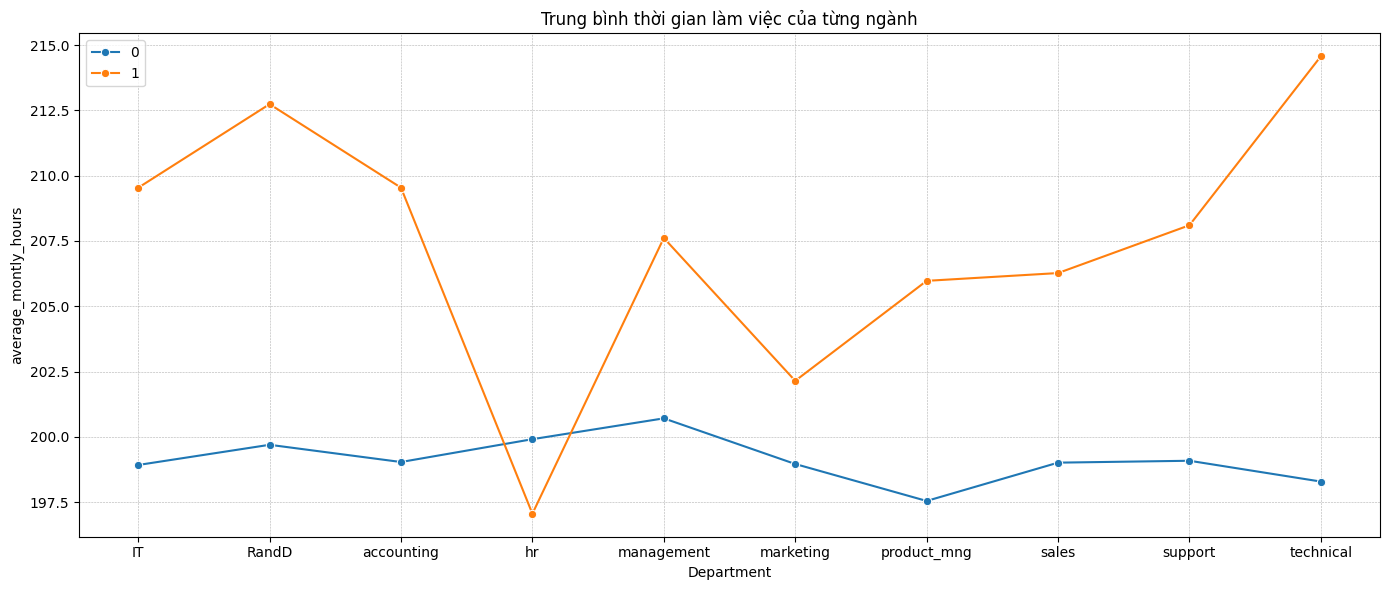

In [177]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_Dep, x='Department', y=dep_0['average_montly_hours'], marker='o', label='0')
sns.lineplot(data=df_Dep, x='Department', y=dep_1['average_montly_hours'], marker='o', label='1')
plt.title('Trung bình thời gian làm việc của từng ngành')
plt.ylabel('average_montly_hours')
plt.grid(True, which='both', linestyle='--', linewidth=0.4)
plt.tight_layout()
plt.show()

- Từ con số trên đây cho ta thấy đây có thể là một công ty có lịch làm việc từ Thứ 2 - Thứ 7 (Với 8.9 tiếng mỗi ngày). Con số trên được tính từ thời gian làm việc của phòng Technical và lượng nghỉ việc cao thứ 2 so với các phòng ban khác.

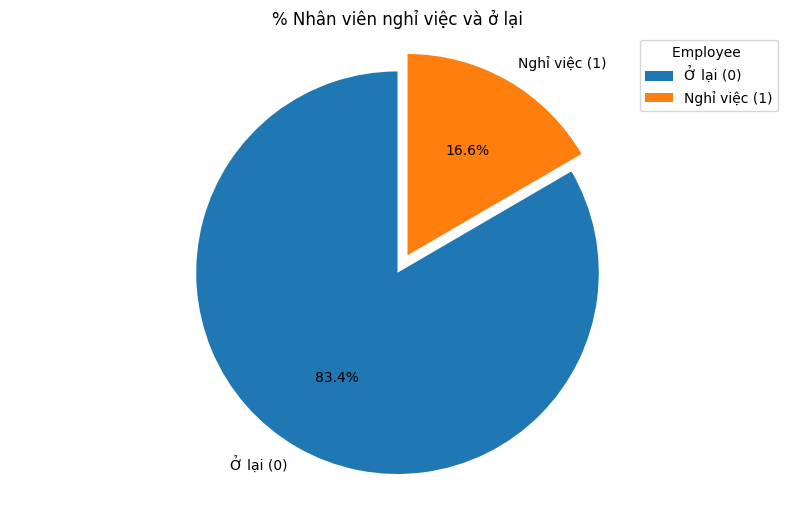

In [78]:
counts_left = df_visualization['left'].value_counts()
labels = ['Ở lại (0)', 'Nghỉ việc (1)']
plt.figure(figsize=(10, 6))
plt.pie(counts_left, labels=labels, autopct='%1.1f%%', startangle=90, explode=(0, 0.1))
plt.title('% Nhân viên nghỉ việc và ở lại')
plt.legend(title='Employee ', labels=['Ở lại (0)', 'Nghỉ việc (1)'])
plt.axis('equal')
plt.show()

- Biểu đồ trên cho thấy một vấn đề gặp phải đó là dữ liệu đang bị mất cân bằng. lượng người nghỉ việc chiếm không nhiều so với lượng nhân viên ở lại.


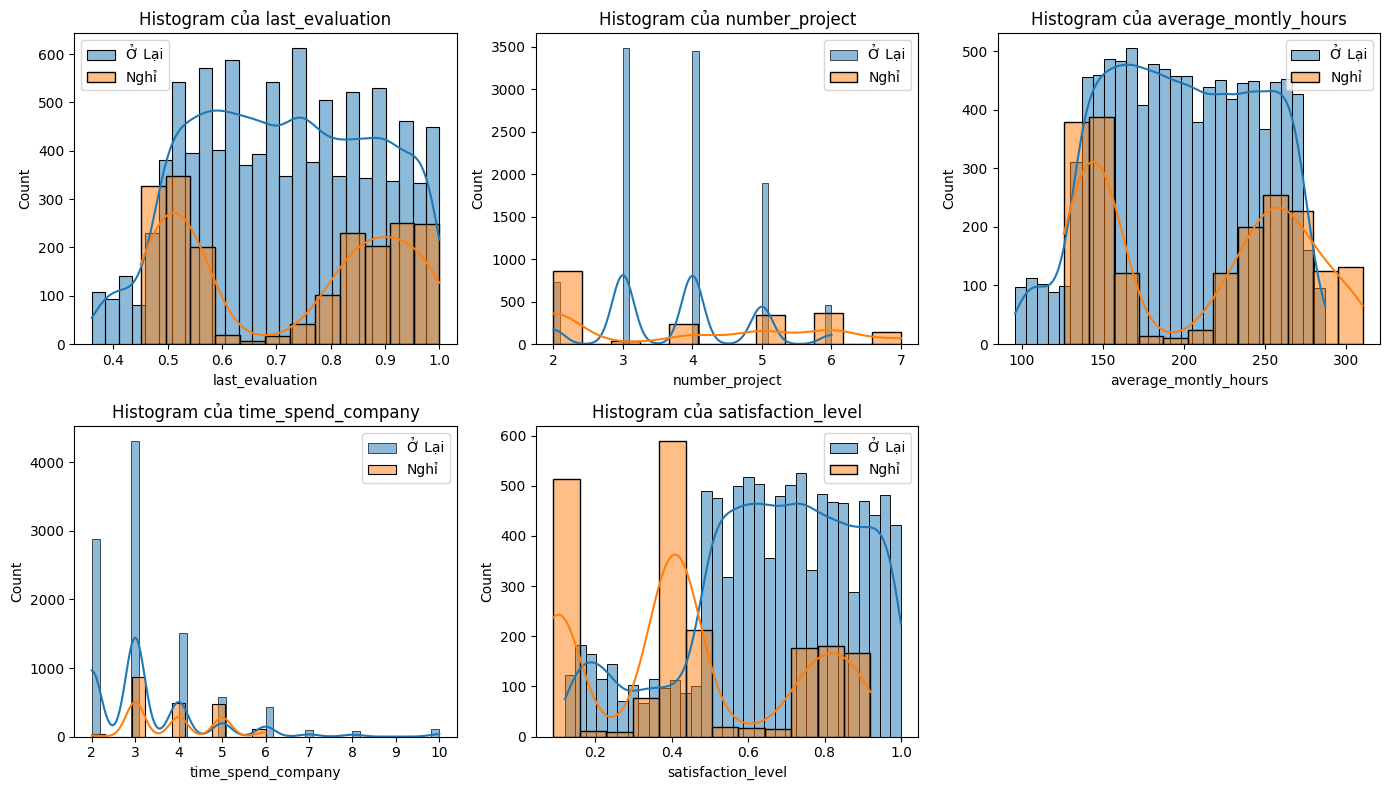

In [79]:
# Plot histogram for satisfaction_level
subplot_flag = 1
plt.figure(figsize=(14, 8))
for i in ['last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company','satisfaction_level'] :    
    plt.subplot(2, 3, subplot_flag)
    sns.histplot(classe_0[classe_0['left'] == 0][i], kde=True, label='Ở Lại')
    sns.histplot(classe_1[classe_1['left'] == 1][i], kde=True,  label='Nghỉ')
    title =  'Histogram của ' + i 
    plt.xlabel(i)
    plt.ylabel('Count')
    plt.title(title)
    plt.legend()
    subplot_flag = subplot_flag + 1
plt.tight_layout()
plt.show()

Điểm đánh giá (`last_evaluation`) :

- Biểu đồ histogram cho thấy những nhân viên có cả điểm đánh giá thấp (dưới 0,5) và điểm cao (trên 0,85) có xu hướng nghỉ việc thường xuyên hơn. Điều này cho thấy cả hiệu suất kém và có thể là làm việc quá sức hoặc kỳ vọng cao đều có thể khiến nhân viên nghỉ việc. Những người có điểm đánh giá trung bình có xu hướng ở lại.

Số lượng dự án (`number_project`) :

- Hầu hết nhân viên có 2 đến 4 dự án , những người làm việc trên 2 hoặc 6-7 dự án có nhiều khả năng nghỉ việc hơn. Những nhân viên làm việc trên số lượng dự án có thể quản lý được (3-4) có vẻ ổn định hơn và có xu hướng ở lại.

Giờ làm việc trung bình hàng tháng (`average_montly_hours`) :

- Những nhân viên làm việc từ 150-200 giờ mỗi tháng có nhiều khả năng ở lại hơn. Tuy nhiên, những người làm việc ít hơn 150 giờ hoặc nhiều hơn 250 giờ có tỷ lệ nghỉ việc cao hơn. Điều này cho thấy cả việc sử dụng không hết công suất và làm việc quá sức đều có thể dẫn đến tỷ lệ nghỉ việc cao hơn.

Thời gian làm việc tại Công ty (`time_spend_company`) :

- Một số lượng lớn nhân viên nghỉ việc sau 3 đến 5 năm làm việc tại công ty

Mức độ hài lòng (`satisfaction_level`) :

- Nhân viên có mức độ hài lòng rất thấp (khoảng 0,2 hoặc thấp hơn) có khả năng nghỉ việc cao hơn nhiều.
Mức độ hài lòng cao hơn (trên 0,6) thường tương ứng với những nhân viên ở lại. Tỷ lệ nghỉ việc giảm đáng kể đối với những nhân viên có mức độ hài lòng trên 0,7.




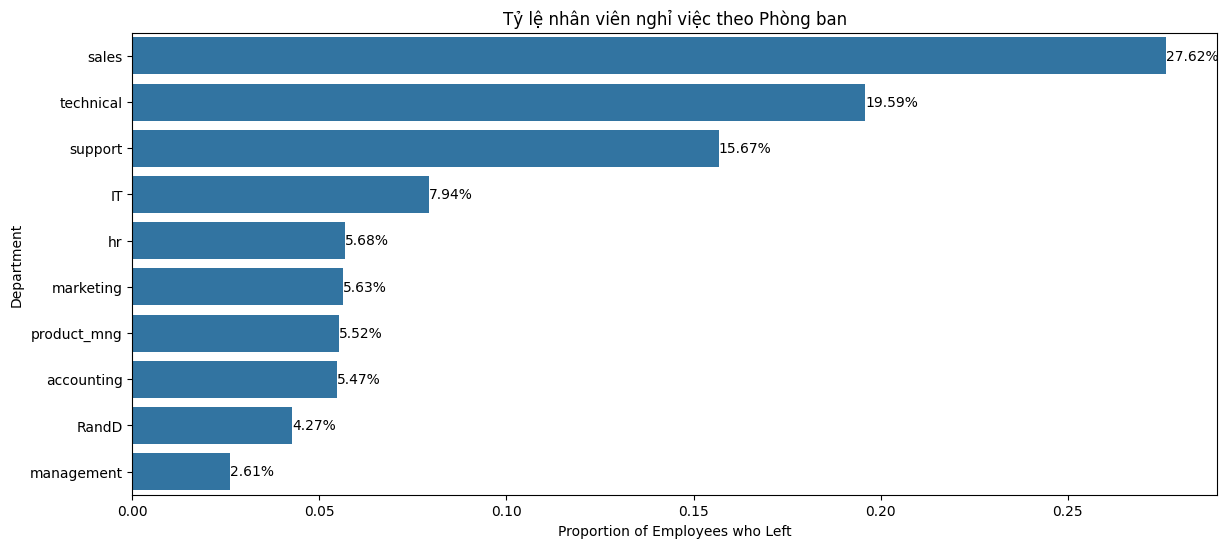

In [80]:
left_by_department = classe_1[classe_1['left'] == 1]['Department'].value_counts(normalize=True)

left_by_department = left_by_department.sort_values(ascending=False)

plt.figure(figsize=(14, 6))
# colors = sns.color_palette('viridis', len(left_by_department))
ax = sns.barplot(x=left_by_department.values, y=left_by_department.index)
plt.xlabel('Proportion of Employees who Left')
plt.ylabel('Department')
plt.title('Tỷ lệ nhân viên nghỉ việc theo Phòng ban')

for i, value in enumerate(left_by_department.values):
    ax.text(value, i, f'{value:.2%}', va='center')
plt.show()

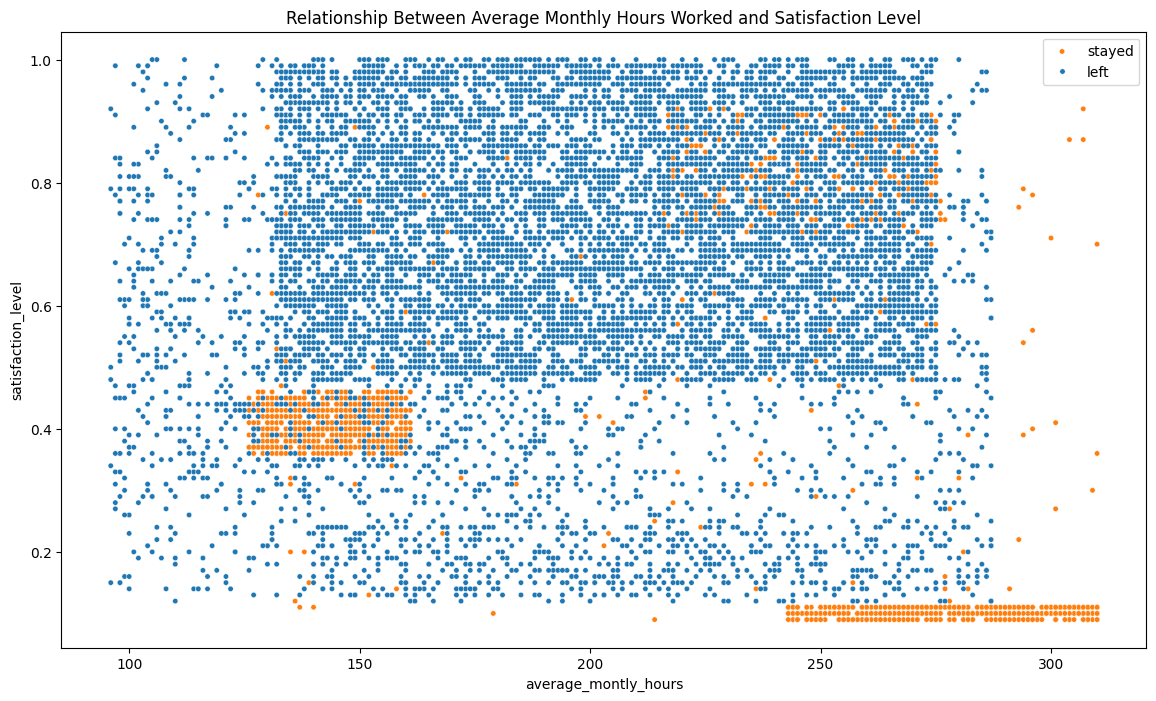

In [81]:
labels = ['stayed','left']
plt.figure(figsize=(14,8))
sns.scatterplot(data=df_visualization, x='average_montly_hours', y='satisfaction_level', hue='left',  alpha=1, s=15)
plt.legend(labels)
plt.title('Relationship Between Average Monthly Hours Worked and Satisfaction Level')
plt.show()

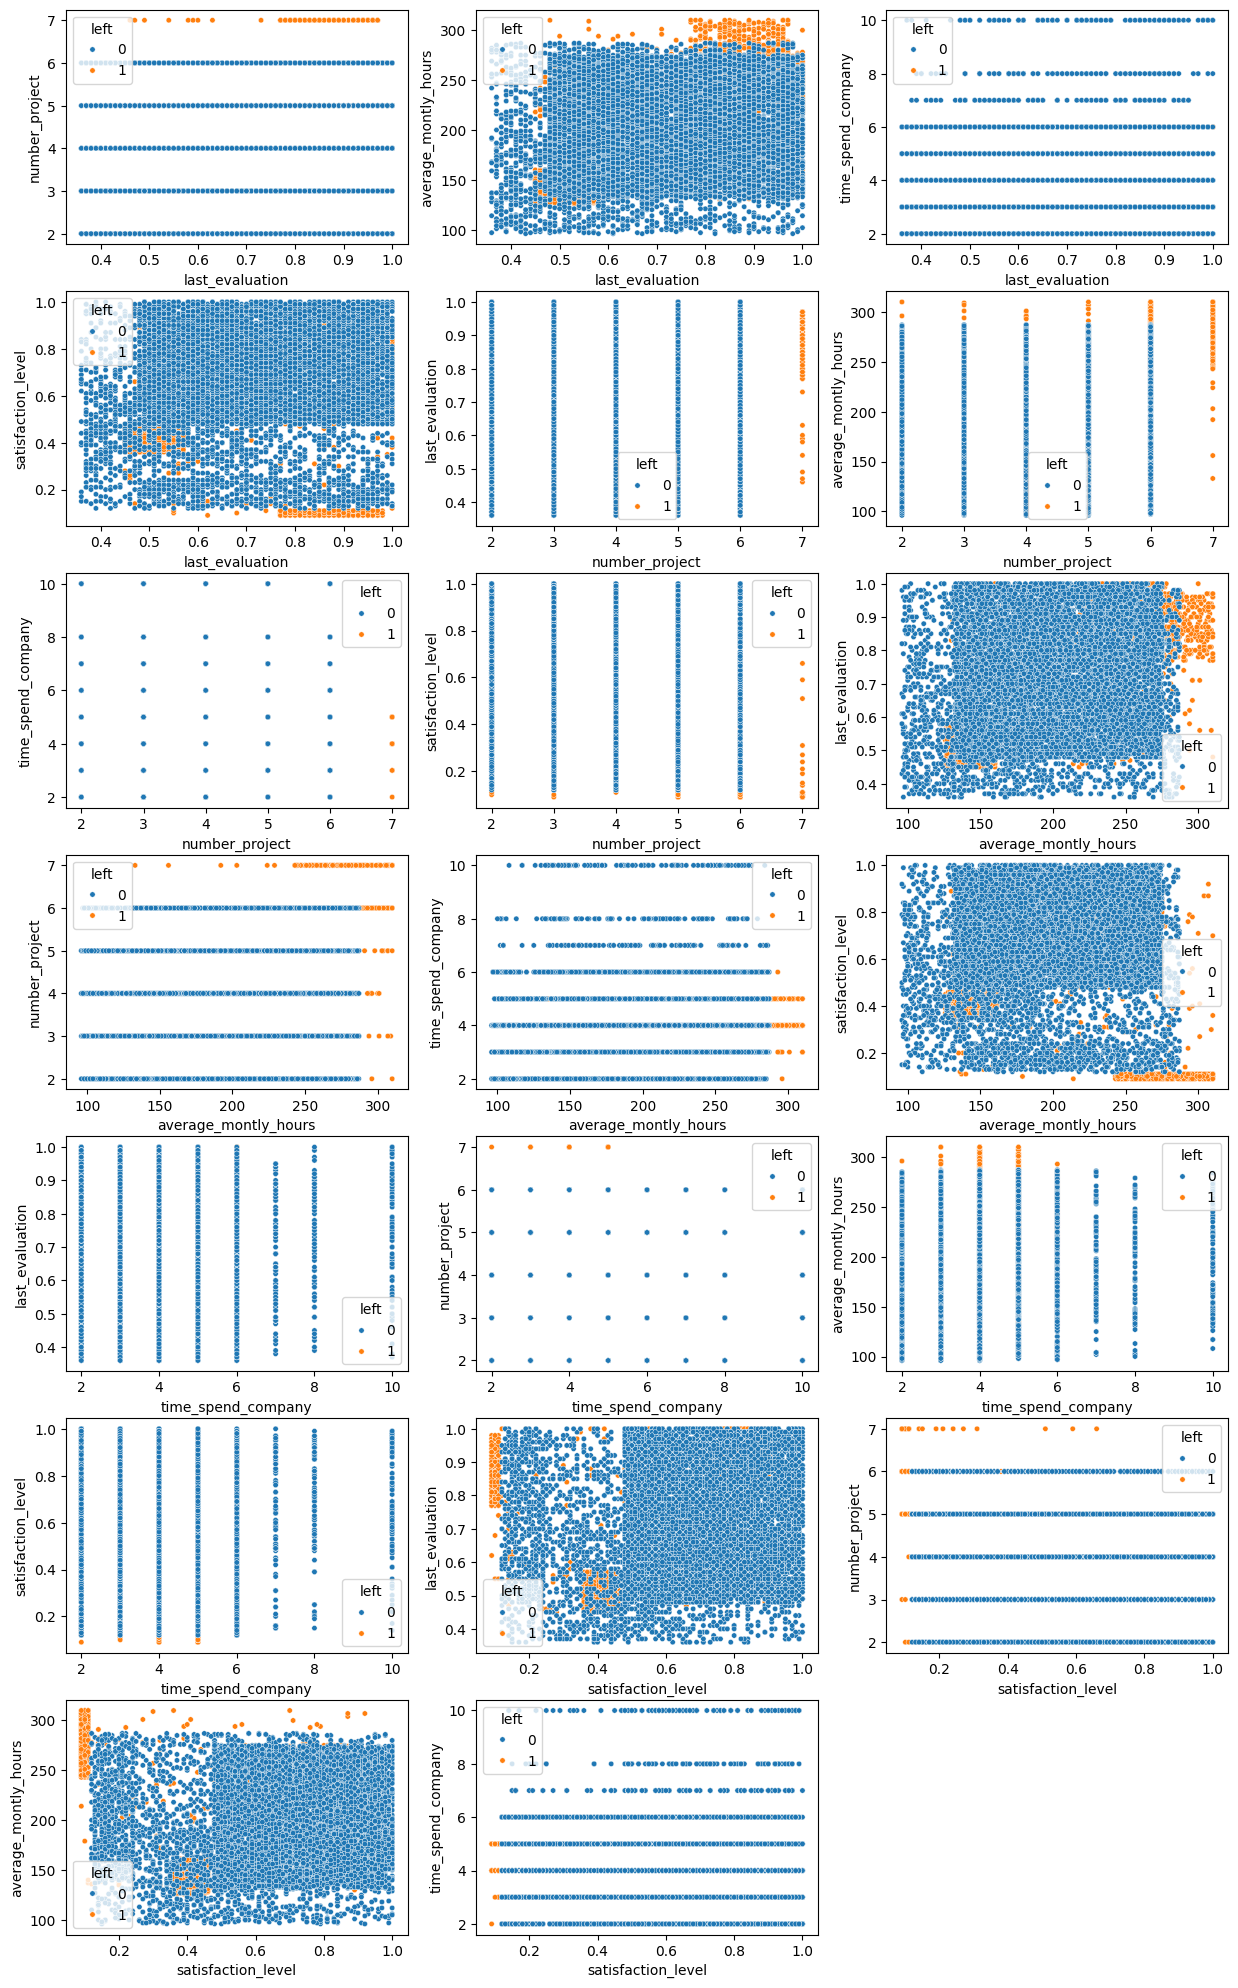

In [82]:
scatterplot_flag = 1
labels = ['stayed','left']
plt.figure(figsize=(15,25))
for i in ['last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company','satisfaction_level']:
    for item in ['last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company','satisfaction_level'] :
        if i != item :
            plt.subplot(7, 3, scatterplot_flag)
            sns.scatterplot(data=df_visualization, x=i, y=item, hue='left',  alpha=1, s=15)
            scatterplot_flag = scatterplot_flag + 1
plt.show()



- Những nhân viên làm nhiều dự án (khoảng 6 hoặc 7 dự án) có khả năng rời khỏi công ty cao, đặc biệt là những người có điểm đánh giá thấp

- Số lượng dự án so với số giờ làm việc trung bình hàng tháng cho thấy những người xử lý nhiều dự án có xu hướng làm việc nhiều giờ hơn (gần 250-300 giờ mỗi tháng) 
- Biểu đồ so sánh thời gian làm việc tại công ty với các số liệu khác cho thấy nhân viên có xu hướng nghỉ việc sau 3-6 năm làm việc, với tỷ lệ nghỉ việc rõ rệt hơn sau khoảng 5 năm.

> Khối lượng công việc và sự không hài lòng dường như là những yếu tố chính dẫn đến tình trạng hao hụt nhân sự.

### 4. Chuyển đổi chiều dữ liệu

In [83]:
def binary_to_bool(data, label):
    """
    Thay các giá trị nhị phân của đặc trưng thành kiểu giá trị bool
    """
    list_value = []
    for i in data[label]:
        list_value.append(True) if i == 1 else list_value.append(False)
    data[label] = list_value
    return data
    


In [84]:
def One_Hot_Encoding(data , label):
    """
    Biến mỗi giá trị phân loại thành một cột riêng biệt với giá trị nhị phân (0 hoặc 1).
    Data: dữ liệu đầu vào
    label: kiểu dữ liệu string, tên các cột cần chuyển đổi.
    """
    list_value = []
    for i in data[label] :
        if i not in list_value:
            list_value.append(i)
    for item in list_value:
        binary_value = []
        for i in data[label]:
            binary_value.append(True) if i == item else binary_value.append(False)
        data[item] = binary_value
    data = data.drop(label, axis=1)
    return data

In [85]:
df_visualization = One_Hot_Encoding(data=df_visualization, label='salary')
df_visualization = One_Hot_Encoding(data=df_visualization, label='Department')

In [86]:
df_visualization.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11991 entries, 0 to 11999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     11991 non-null  float64
 1   last_evaluation        11991 non-null  float64
 2   number_project         11991 non-null  int64  
 3   average_montly_hours   11991 non-null  int64  
 4   time_spend_company     11991 non-null  int64  
 5   Work_accident          11991 non-null  int64  
 6   left                   11991 non-null  int64  
 7   promotion_last_5years  11991 non-null  int64  
 8   low                    11991 non-null  bool   
 9   medium                 11991 non-null  bool   
 10  high                   11991 non-null  bool   
 11  sales                  11991 non-null  bool   
 12  accounting             11991 non-null  bool   
 13  hr                     11991 non-null  bool   
 14  technical              11991 non-null  bool   
 15  support

In [87]:
df_visualization = binary_to_bool(data=df_visualization, label='Work_accident')
df_visualization = binary_to_bool(data=df_visualization, label='left')
df_visualization = binary_to_bool(data=df_visualization, label='promotion_last_5years')



In [88]:
df_visualization.to_csv('./HR.csv', index=None)

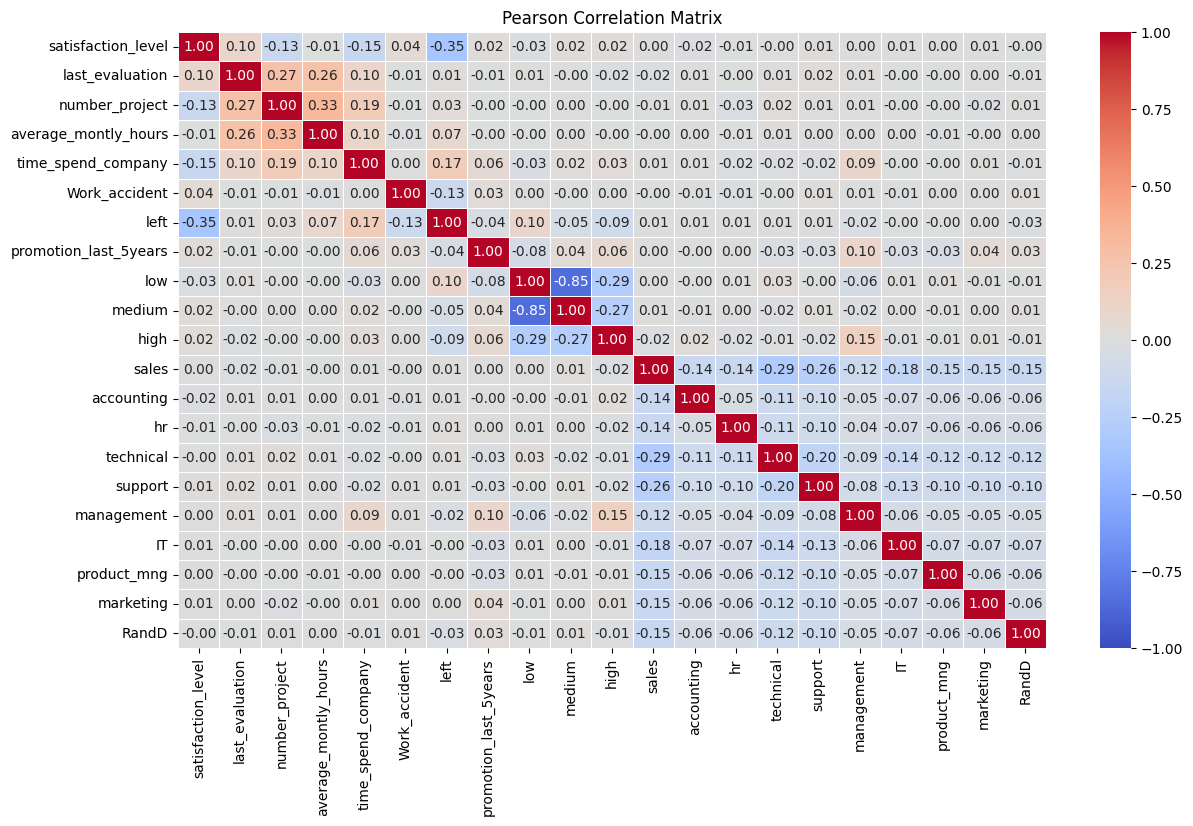

In [89]:
corr_matrix = df_visualization.corr(method='pearson')
plt.figure(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

### 5. Kiểm tra Chi-Square

In [90]:
data = pd.read_csv('./HR.csv')

In [91]:
le = LabelEncoder()

- Loại bỏ các biến liên tục

In [92]:
drop_ft = ['left']

- Mã hóa các đặc trưng phân loại bằng LabelEncoder

In [93]:
x = data.drop(drop_ft, axis=1).apply(le.fit_transform)
y = data['left']


- Tính toán giá trị Chi-Square và giá trị p-value

In [94]:
chi2_scores, p_values = chi2(x, y)

In [95]:
chi2_results = pd.DataFrame({
    'Feature': x.columns,
    'Chi2 Score': chi2_scores,
    'P-Value': p_values
})
# Hiển thị kết quả
print(chi2_results.sort_values(by='Chi2 Score', ascending=False))

                  Feature    Chi2 Score        P-Value
0      satisfaction_level  15867.468772   0.000000e+00
3    average_montly_hours   1350.912403  9.758983e-296
4      time_spend_company    486.281996  9.179387e-108
5           Work_accident    159.561439   1.410813e-36
9                    high     98.802269   2.790145e-23
7                     low     61.406110   4.643673e-15
6   promotion_last_5years     23.508493   1.243636e-06
1         last_evaluation     17.412950   3.007699e-05
8                  medium     15.002340   1.073779e-04
19                  RandD      9.511101   2.042325e-03
2          number_project      8.607754   3.347348e-03
15             management      6.889001   8.672770e-03
12                     hr      2.096625   1.476247e-01
13              technical      0.974748   3.234988e-01
11             accounting      0.403223   5.254296e-01
14                support      0.368461   5.438443e-01
10                  sales      0.331450   5.648063e-01
17        

In [96]:
chi2_results = chi2_results.sort_values('Chi2 Score',ascending=False).reset_index()

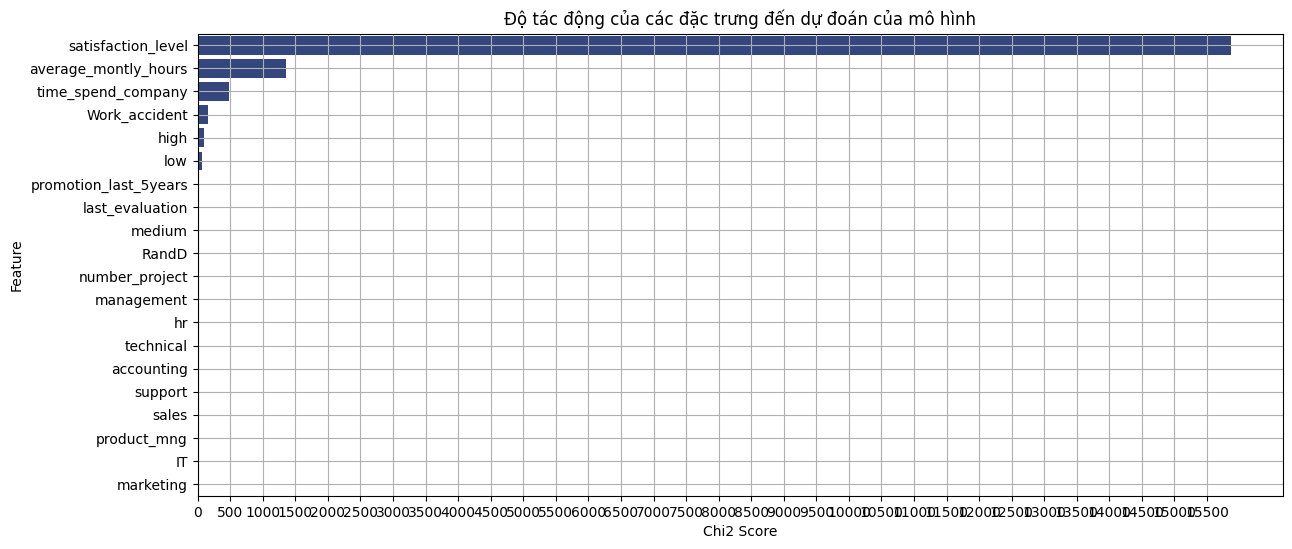

In [97]:
plt.figure(figsize=(14,6))
sns.barplot(x=chi2_results['Chi2 Score'], y=chi2_results['Feature'], data=chi2_results, dodge=True, color='#27408B')
plt.xticks(np.arange(0, 16000, 500))
plt.title('Độ tác động của các đặc trưng đến dự đoán của mô hình')
plt.grid(visible=True)
plt.show()



###  6. Mutual Information

In [98]:
mi_scores = mutual_info_classif(x, y)
mi_scores = pd.Series(mi_scores, index=x.columns).sort_values(ascending=False).reset_index()

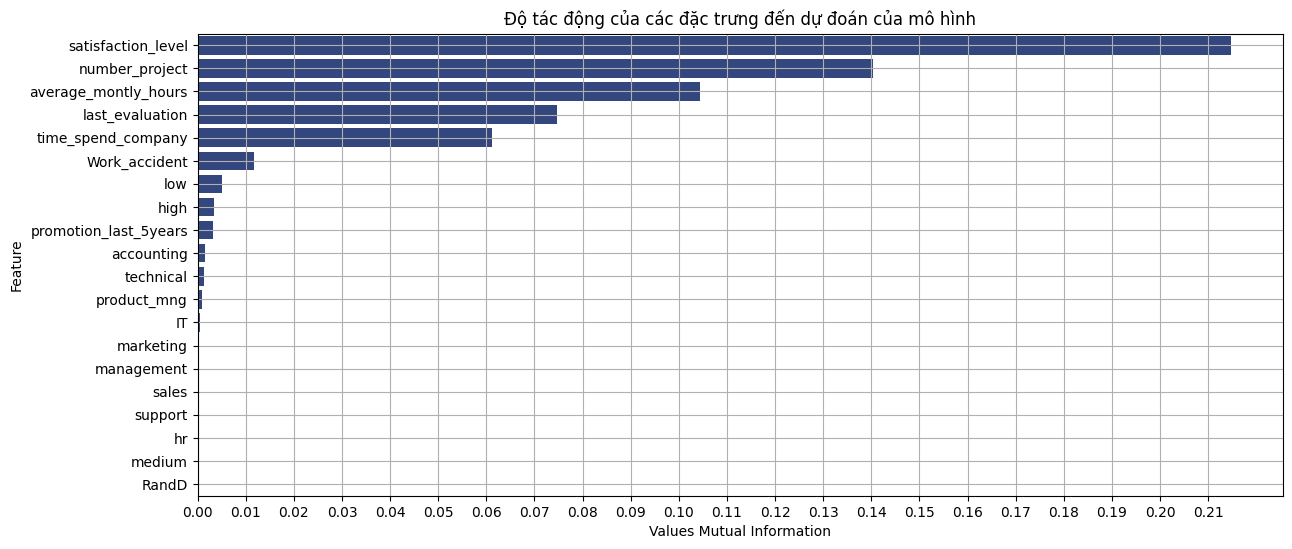

In [99]:
plt.figure(figsize=(14,6))
sns.barplot(x=mi_scores[0], y=mi_scores['index'], data=mi_scores, dodge=True, color='#27408B')
plt.xticks(np.arange(0, 0.22, 0.01))
plt.grid(visible=True)
plt.title('Độ tác động của các đặc trưng đến dự đoán của mô hình')
plt.xlabel("Values Mutual Information")
plt.ylabel("Feature")
plt.show()

### 7. Modeling

-  Tỷ lệ phần trăm cân bằng dữ liệu cho thấy khoảng 83,4% nhân viên ở lại công ty (`False`), trong khi chỉ có khoảng 16,6% nhân viên rời công ty (`True`).

In [100]:
data_balance = data['left'].value_counts()
data_balance_percentage = data_balance / len(data) * 100
print("Data Balance Percentage:")
print(data_balance_percentage)

Data Balance Percentage:
left
False    83.39588
True     16.60412
Name: count, dtype: float64


- Vấn đề tiếp theo đó là dữ liệu đang bị mất cân bằng, tỉ lệ người ở lại công ti so với những người rời đi chênh lệnh khá lớn. 

- Tứ phân vị

In [101]:
Q1 = data['time_spend_company'].quantile(0.25)
Q3 = data['time_spend_company'].quantile(0.75)
IQR = Q3 - Q1


* Loại bỏ các giá trị ngoại lai trong tứ phân vị để đưa dữ liệu vào Model

In [102]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data_model = data[(data['time_spend_company'] >= lower_bound) & (data['time_spend_company'] <= upper_bound)]

In [103]:
data_model.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company
count,11167.000000,11167.000000,11167.000000,11167.000000,11167.000000
mean,0.631944,0.715901,3.786066,200.144533,3.109161
std,0.239064,0.167595,1.164198,48.563047,0.899277
min,0.090000,0.360000,2.000000,96.000000,2.000000
25%,0.490000,0.570000,3.000000,157.000000,2.000000
50%,0.660000,0.720000,4.000000,199.000000,3.000000
75%,0.820000,0.860000,5.000000,243.000000,4.000000
max,1.000000,1.000000,7.000000,310.000000,5.000000


### 8. Chọn đặc trưng

##### Recursive Feature Elimination (RFE)

- Chia tập dữ liệu

In [104]:
drop_feature = ['satisfaction_level', 'left',  'management', 'hr', 
                'technical', 'accounting', 'support' ,'sales','product_mng', 'IT', 'marketing']

In [105]:
x = data_model.drop(drop_feature, axis=1)
y = data_model['left']

- Random Forest 


In [106]:
model_randomForest = RandomForestClassifier()

In [107]:
rfe_random = RFE(model_randomForest, n_features_to_select=5)  # Chọn 5 đặc trưng quan trọng nhất
fit = rfe_random.fit(x, y)

In [108]:
print("Các đặc trưng quan trọng được chọn:", x.columns[fit.support_])

Các đặc trưng quan trọng được chọn: Index(['last_evaluation', 'number_project', 'average_montly_hours',
       'time_spend_company', 'Work_accident'],
      dtype='object')


- Logistic Regression

In [109]:
model_LR = LogisticRegression()

In [110]:
rfe_logistic = RFE(model_LR, n_features_to_select=5)  # Chọn 5 đặc trưng quan trọng nhất
fit = rfe_logistic.fit(x, y)

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [111]:
print(x.columns[fit.support_])

Index(['last_evaluation', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'high'],
      dtype='object')


### 9. Chia dữ liệu thành các tập train, validation, test 

In [112]:
X = data_model.drop('left', axis=1)
y = data_model['left']

- Tập Train

Trong bài toán trên, dữ liệu ta đang sử dụng đang gặp một vấn đề đó là mất cân bằng. Để giải quyết vấn đề này ta sẽ sử dụng phương pháp lấy mẫu Undersampling. 

In [158]:
# Chia dữ liệu train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
undersample = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train, y_train)


In [159]:
print("Số lượng lớp trong tập train trước khi undersample:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Số lượng lớp trong tập train sau khi undersample:", dict(zip(*np.unique(y_train_resampled, return_counts=True))))


Số lượng lớp trong tập train trước khi undersample: {False: 6499, True: 1317}
Số lượng lớp trong tập train sau khi undersample: {False: 1317, True: 1317}


In [160]:
print("Số lượng lớp trong tập train trước khi undersample:", dict(zip(*np.unique(y_test, return_counts=True))))


Số lượng lớp trong tập train trước khi undersample: {False: 2786, True: 565}


- Chia tập validation, test

Để đánh giá đúng chính xác mô hình ta vẫn sẽ giữ nguyên cách lấy mẫu tập validation và tập test để cho ra kết quả đánh giá chính xác nhất

In [161]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)
print("Tỷ lệ lớp trong tập validation:", dict(zip(*np.unique(y_val, return_counts=True))))
print("Tỷ lệ lớp trong tập test:", dict(zip(*np.unique(y_test, return_counts=True))))

Tỷ lệ lớp trong tập validation: {False: 1858, True: 376}
Tỷ lệ lớp trong tập test: {False: 1857, True: 377}


### 10. Logistic Regression Model 

- Tinh chỉnh siêu tham số và mô hình

In [174]:
param_grid = {
    'C': [0.05,0.14,0.13,0.12,0.11,0.1,0.15, 0.2, 0.25],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

lr = LogisticRegression(random_state=42)

grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy') 
grid_search.fit(X_train_resampled, y_train_resampled)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_

Best parameters: {'C': 0.13, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.8781293064263606


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_

In [175]:
best_lr = grid_search.best_estimator_
y_pred = best_lr.predict(X_test)


- Chỉ số đánh giá 

In [176]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)




Confusion Matrix:
[[1485  372]
 [  21  356]]

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.80      0.88      1857
        True       0.49      0.94      0.64       377

    accuracy                           0.82      2234
   macro avg       0.74      0.87      0.76      2234
weighted avg       0.90      0.82      0.84      2234

Best parameters: {'C': 0.13, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.8781293064263606


- Để cải thiện việc dự đoán cho mô hình, dữ liệu cần được thu thập thêm để tránh khỏi việc mất cân bằng dữ liệu.

- tỉ lệ dự đoán của mô hình nằm ở mức tương đối. Dự đoán những nhân viên nghỉ việc chỉ chiếm tới 50%. Độ chính xác của mô hình lên tới 87% và đây là một con số tương đối ổn, không quá tệ.